라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
model_name = 'Test230530-01_LSTMJaponicaTank1'

# 한글 글꼴 경로 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 원하는 한글 글꼴 파일 경로로 수정해주세요
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='actual')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('날짜')
    plt.ylabel('DO')
    plt.title('시계열')
    plt.legend(['y_test','X_pred'])
    plt.show()
    
    # 평가 생성
    #result = model.evaluate(X_test_shape, y_test)
    #print("MSE // MAE // R-squared ", result)
    

데이터셋 설정

In [ ]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")

#자포니카 훈련 데이터 시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

#자포니카 검증 데이터 시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

#자포니카 훈련 및 검증 데이터 시계열 변환
japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

In [ ]:
# first_day = japonica_training.mea_dt.min().ceil('D')  # 첫째 날의 시작 시각
# last_day = japonica_training.mea_dt.max().floor('D')    # 마지막 날의 마지막 시각

# # 첫째 날과 마지막 날에 해당하는 행을 삭제
# japonica_training = japonica_training.loc[(japonica_training.mea_dt > first_day) & (japonica_training.mea_dt < last_day)]

# first_day = japonica_validation.mea_dt.min().ceil('D')  # 첫째 날의 시작 시각
# last_day = japonica_validation.mea_dt.max().floor('D')    # 마지막 날의 마지막 시각

# # 첫째 날과 마지막 날에 해당하는 행을 삭제
# japonica_validation = japonica_validation.loc[(japonica_validation.mea_dt > first_day) & (japonica_validation.mea_dt < last_day)]

In [ ]:
# last_day

In [ ]:
# 날짜 데이터를 인덱스로 전환
japonica_training.set_index('mea_dt', inplace=True)
japonica_validation.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training = japonica_training.sort_index()
japonica_validation = japonica_validation.sort_index()

In [ ]:
japonica_training

In [ ]:
# 사용할 features 선택
feature_origin = ['tank_id','do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

In [ ]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_training_features_tank = japonica_training_features[japonica_training_features['tank_id']==tank]
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

In [ ]:
japonica_training_features_tank

In [ ]:
japonica_training_features_tank_save = japonica_training_features_tank
japonica_training_features_tank_save = japonica_training_features_tank_save.reset_index()
japonica_training_features_tank_save

In [ ]:
japonica_training_features_tank_save.to_csv('data1.csv', index=False)

In [ ]:
# 시계열 데이터의 개수 확인
counts = japonica_training_features_tank.groupby(japonica_training_features_tank.index.date).size()

# 개수가 1440보다 작은 시계열 삭제
to_delete = counts[counts < 1435].index
data = japonica_training_features_tank[~japonica_training_features_tank.index.floor('D').isin(to_delete)]

print(data)

In [ ]:
japonica_training_features_tank_save = data
japonica_training_features_tank_save = japonica_training_features_tank_save.reset_index()
japonica_training_features_tank_save
japonica_training_features_tank_save.to_csv('data1.csv', index=False)

In [3]:
japonica_training_data = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/data.csv")
japonica_training_data['mea_dt'] = pd.to_datetime(japonica_training_data['mea_dt'], format='mixed', errors='raise')
japonica_training_data.set_index('mea_dt', inplace=True)
japonica_training_data = japonica_training_data[['tank_id','do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_training_data

,tank_id,do_mg,do_temp,ph,orp,co2_mg,air_oxy,light_ma,feed_quantity,water_quantity
mea_dt,,,,,,,,,,
2021-07-16 00:00:00,1,8.3,30.4,5.63,156.0,15.4,0.0,3.9,0.0,0.0
2021-07-16 00:01:00,1,8.4,30.4,5.63,155.7,15.4,0.0,3.9,0.0,0.0
2021-07-16 00:02:00,1,8.4,30.4,5.63,155.8,15.4,0.0,4.0,0.0,0.0
2021-07-16 00:03:00,1,8.4,30.4,5.63,156.0,15.4,0.0,4.0,0.0,0.0
2021-07-16 00:04:00,1,8.4,30.4,5.62,156.3,15.4,0.0,3.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-01-05 23:55:00,1,12.0,28.7,5.19,222.8,31.2,11.4,4.0,0.0,0.0
2022-01-05 23:56:00,1,12.0,28.7,5.19,222.8,31.1,11.2,4.0,0.0,0.0
2022-01-05 23:57:00,1,12.0,28.7,5.18,222.9,31.1,11.1,4.0,0.0,0.0


In [4]:
japonica_training_features_X = japonica_training_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]
# japonica_validation_features_X = japonica_validation_features_tank[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
# japonica_validation_features_y = japonica_validation_features_tank[['do_mg']]

In [5]:
japonica_training_features_X_chunks = []

for i in range(0, len(japonica_training_features_X) - 179):
    japonica_training_features_X_chunks.append(np.array(japonica_training_features_X.iloc[i:i+180].values, dtype=np.float64))
    
    # for j in range(0, 180):
    #     nested_chunk = []
    #     for col in japonica_training_features_X.columns:
    #         values = japonica_training_features_X[col].values
    #         nested_values = values[i+j:i+j+10]
    #         nested_chunk.append(nested_values)
    #     chunk.append(nested_chunk)
    # japonica_training_features_X_chunks.append(chunk)

japonica_training_features_X_chunks = np.array(japonica_training_features_X_chunks, dtype=np.float64)

In [27]:
japonica_training_features_X_chunks

array([[[ 8.3 , 30.4 ,  5.63, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.4 , 30.4 ,  5.63, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.4 , 30.4 ,  5.63, ...,  4.  ,  0.  ,  0.  ],
        ...,
        [ 8.6 , 30.4 ,  5.33, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.6 , 30.4 ,  5.33, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.6 , 30.4 ,  5.32, ...,  4.  ,  0.  ,  0.  ]],

       [[ 8.4 , 30.4 ,  5.63, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.4 , 30.4 ,  5.63, ...,  4.  ,  0.  ,  0.  ],
        [ 8.4 , 30.4 ,  5.63, ...,  4.  ,  0.  ,  0.  ],
        ...,
        [ 8.6 , 30.4 ,  5.33, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.6 , 30.4 ,  5.32, ...,  4.  ,  0.  ,  0.  ],
        [ 8.6 , 30.4 ,  5.32, ...,  4.  ,  0.  ,  0.  ]],

       [[ 8.4 , 30.4 ,  5.63, ...,  4.  ,  0.  ,  0.  ],
        [ 8.4 , 30.4 ,  5.63, ...,  4.  ,  0.  ,  0.  ],
        [ 8.4 , 30.4 ,  5.62, ...,  3.9 ,  0.  ,  0.  ],
        ...,
        [ 8.6 , 30.4 ,  5.32, ...,  4.  ,  0.  ,  0.  ],
        [ 8.6 , 30.4 ,  5.32, ...,  4.  ,  0.

In [6]:
japonica_training_features_y_chunks = []

for i in range(0, len(japonica_training_features_y) - 179):
    japonica_training_features_y_chunks.append(np.array(japonica_training_features_y.iloc[i:i+180].values, dtype=np.float64))
    # for j in range(0, 180):
    #     nested_chunk = []
    #     for col in japonica_training_features_X.columns:
    #         values = japonica_training_features_X[col].values
    #         nested_values = values[i+j:i+j+10]
    #         nested_chunk.append(nested_values)
    #     chunk.append(nested_chunk)
    # japonica_training_features_X_chunks.append(chunk)

japonica_training_features_y_chunks = np.array(japonica_training_features_y_chunks, dtype=np.float64)

In [29]:
japonica_training_features_y_chunks

array([[[ 8.3],
        [ 8.4],
        [ 8.4],
        ...,
        [ 8.6],
        [ 8.6],
        [ 8.6]],

       [[ 8.4],
        [ 8.4],
        [ 8.4],
        ...,
        [ 8.6],
        [ 8.6],
        [ 8.6]],

       [[ 8.4],
        [ 8.4],
        [ 8.4],
        ...,
        [ 8.6],
        [ 8.6],
        [ 8.7]],

       ...,

       [[ 9.6],
        [ 9.6],
        [ 9.6],
        ...,
        [12. ],
        [12. ],
        [12. ]],

       [[ 9.6],
        [ 9.6],
        [ 9.5],
        ...,
        [12. ],
        [12. ],
        [12.1]],

       [[ 9.6],
        [ 9.5],
        [ 9.5],
        ...,
        [12. ],
        [12.1],
        [12.1]]])

In [7]:
# LSTM학습을 위해 데이터 reshape를 해야함. reshape를 위해 배열형으로 변환
japonica_training_features_X_re = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_training_features_y_re = np.asarray(japonica_training_features_y, dtype=np.float64)
#japonica_validation_features_X_reshape = np.asarray(japonica_validation_features_X, dtype=np.float64)

# 데이터를 3항으로 reshape. (batch_size, timesteps, features)
# batch_size: 한 번에 모델에 입력되는 샘플의 개수
# timesteps: 입력되는 시퀀스 데이터의 길이(시간축)
# features: 입력되는 데이터의 특성 개수
# 말이 어려우니까 쉽게 쓰면 (얼마 만큼의 샘플을, 시간 당 몇 개씩, 항목이 몇 개인가)
# (-1 : 있는 만큼의 샘플을, 1 : 시간당 1개씩, 8 : 피처는 8개입니다.)
japonica_training_features_X_reshape = japonica_training_features_X_re.reshape((-1, 180, 9))
japonica_training_features_y_reshape = japonica_training_features_y_re.reshape((-1, 180, 1))
#japonica_validation_features_X_reshape = japonica_validation_features_X_reshape.reshape((-1, 180, 9))

In [36]:
japonica_training_features_X_re

array([[ 8.3 , 30.4 ,  5.63, ...,  3.9 ,  0.  ,  0.  ],
       [ 8.4 , 30.4 ,  5.63, ...,  3.9 ,  0.  ,  0.  ],
       [ 8.4 , 30.4 ,  5.63, ...,  4.  ,  0.  ,  0.  ],
       ...,
       [12.  , 28.7 ,  5.18, ...,  4.  ,  0.  ,  0.  ],
       [12.1 , 28.7 ,  5.18, ...,  4.1 ,  0.  ,  0.  ],
       [12.1 , 28.7 ,  5.18, ...,  3.9 ,  0.  ,  0.  ]])

In [19]:
japonica_training_features_X_reshape

array([[[ 8.3 , 30.4 ,  5.63, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.4 , 30.4 ,  5.63, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.4 , 30.4 ,  5.63, ...,  4.  ,  0.  ,  0.  ],
        ...,
        [ 8.6 , 30.4 ,  5.33, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.6 , 30.4 ,  5.33, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.6 , 30.4 ,  5.32, ...,  4.  ,  0.  ,  0.  ]],

       [[ 8.6 , 30.4 ,  5.32, ...,  4.  ,  0.  ,  0.  ],
        [ 8.7 , 30.4 ,  5.32, ...,  4.  ,  0.  ,  0.  ],
        [ 8.7 , 30.4 ,  5.32, ...,  4.  ,  0.  ,  0.  ],
        ...,
        [ 8.2 , 30.4 ,  5.32, ...,  4.  ,  0.  ,  0.  ],
        [ 8.3 , 30.4 ,  5.33, ...,  4.1 ,  0.  ,  0.  ],
        [ 8.3 , 30.4 ,  5.35, ...,  4.  ,  0.  ,  0.  ]],

       [[ 8.3 , 30.4 ,  5.36, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.2 , 30.4 ,  5.39, ...,  3.9 ,  0.  ,  0.  ],
        [ 8.3 , 30.4 ,  5.41, ...,  4.  ,  0.  ,  0.  ],
        ...,
        [ 8.4 , 30.2 ,  5.57, ...,  4.  ,  0.  ,  0.  ],
        [ 8.4 , 30.2 ,  5.57, ...,  4.  ,  0.

In [8]:
japonica_training_features_X_reshape_crop = japonica_training_features_X_reshape[:-1]
japonica_training_features_y_reshape_crop = japonica_training_features_y_reshape[1:]

In [9]:
# shape확인
nCar = japonica_training_features_X_reshape_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_reshape_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_reshape_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_reshape_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# # shape확인
# nCar = japonica_validation_features_X_reshape.shape[0] # 데이터 개수
# nVar = japonica_validation_features_X_reshape.shape[2] # 변수 개수
# print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# nCar = japonica_validation_features_y.shape[0] # 데이터 개수
# nVar = japonica_validation_features_y.shape[1] # 변수 개수
# print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1143 nVar: 9
nCar: 1143 nVar: 180


In [30]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# # shape확인
# nCar = japonica_validation_features_X_reshape.shape[0] # 데이터 개수
# nVar = japonica_validation_features_X_reshape.shape[2] # 변수 개수
# print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# nCar = japonica_validation_features_y.shape[0] # 데이터 개수
# nVar = japonica_validation_features_y.shape[1] # 변수 개수
# print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 205741 nVar: 9
nCar: 205741 nVar: 180


In [10]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-180]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[180:]

In [11]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )


nCar: 205561 nVar: 9
nCar: 205561 nVar: 180


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [12]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
model.add(LSTM(128, input_shape=(180, 9), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(180, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop, epochs = 200, batch_size = 32, validation_data=(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 180, 128)          70656     
                                                                 
 lstm_1 (LSTM)               (None, 180, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 180)               5940      
                                                                 
Total params: 138,420
Trainable params: 138,420
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
6424/6424 [==============================] - 1571s 244ms/step - loss: 2.3814 - mae: 1.0107 - r_squared: 0.1728 - val_loss: 0.3631 - val_mae: 0.4080 - val_r_squared: -2.78

: 

: 

In [ ]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
model.add(LSTM(128, input_shape=(180, 9), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(180, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_reshape_crop, japonica_training_features_y_reshape_crop, epochs = 200, batch_size = 32, validation_data=(japonica_training_features_X_reshape_crop, japonica_training_features_y_reshape_crop), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

모델 평가

모델 평가

In [7]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[ 0.04350204 -0.0864744   0.05959944 ... -0.03005048 -0.02350662
   0.07711291]
 [ 0.10636365 -0.0003753  -0.04347628 ...  0.03185231 -0.07425465
   0.06523296]
 [ 0.10815308 -0.00210809  0.08234122 ...  0.04656865 -0.04676225
  -0.01881751]
 ...
 [ 0.12399723 -0.03417719  0.06700367 ...  0.00958376  0.03581041
   0.04319176]
 [ 0.02299274 -0.04352631  0.02969136 ... -0.05188783 -0.00688423
  -0.07765491]
 [ 0.09274436 -0.03258373  0.01815024 ...  0.10030288  0.09474745
   0.06767885]]


c:\Users\rladn\anaconda3\envs\doRegressor\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


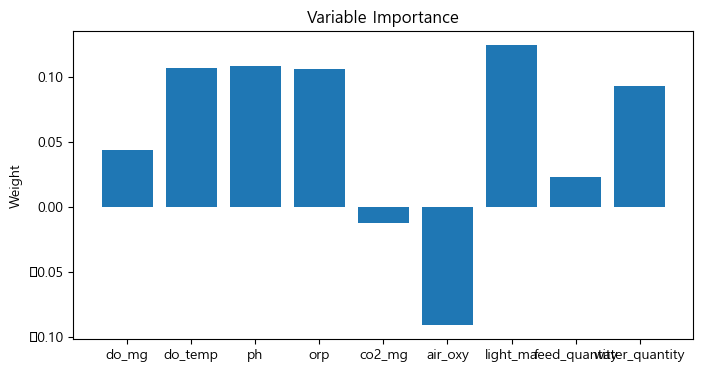

In [33]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(9), weights[:, 0])
ax.set_xticks(range(9))
ax.set_xticklabels(['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [41]:
X_pred = model.predict(japonica_training_features_X_reshape)
X_pred = np.array(X_pred).flatten()

X_pred = pd.DataFrame(X_pred)

start = pd.Timestamp(japonica_training_features_X.index[0]) + pd.Timedelta(hours=3)

# 시계열 인덱스 생성
index = pd.date_range(start, periods=len(X_pred), freq='1min')

# 데이터프레임의 인덱스를 시계열 인덱스로 변경
X_pred.index = index

X_pred

36/36 [==============================] - 2s 65ms/step


,0
2021-07-16 03:00:00,8.415614
2021-07-16 03:01:00,8.394588
2021-07-16 03:02:00,8.390972
2021-07-16 03:03:00,8.407490
2021-07-16 03:04:00,8.435637
...,...
2021-12-06 02:55:00,11.992622
2021-12-06 02:56:00,12.015900
2021-12-06 02:57:00,12.057986
2021-12-06 02:58:00,12.056270


In [42]:
japonica_training_features_y = japonica_training_features_y.reset_index()
japonica_training_features_y['mea_dt'] = pd.to_datetime(japonica_training_features_y['mea_dt'], format='mixed', errors='raise')
japonica_training_features_y.set_index('mea_dt', inplace=True)
japonica_training_features_y

,do_mg
mea_dt,
2021-07-16 00:00:00,8.3
2021-07-16 00:01:00,8.4
2021-07-16 00:02:00,8.4
2021-07-16 00:03:00,8.4
2021-07-16 00:04:00,8.4
...,...
2022-01-05 23:55:00,12.0
2022-01-05 23:56:00,12.0
2022-01-05 23:57:00,12.0


In [ ]:
japonica_training_features_y.index

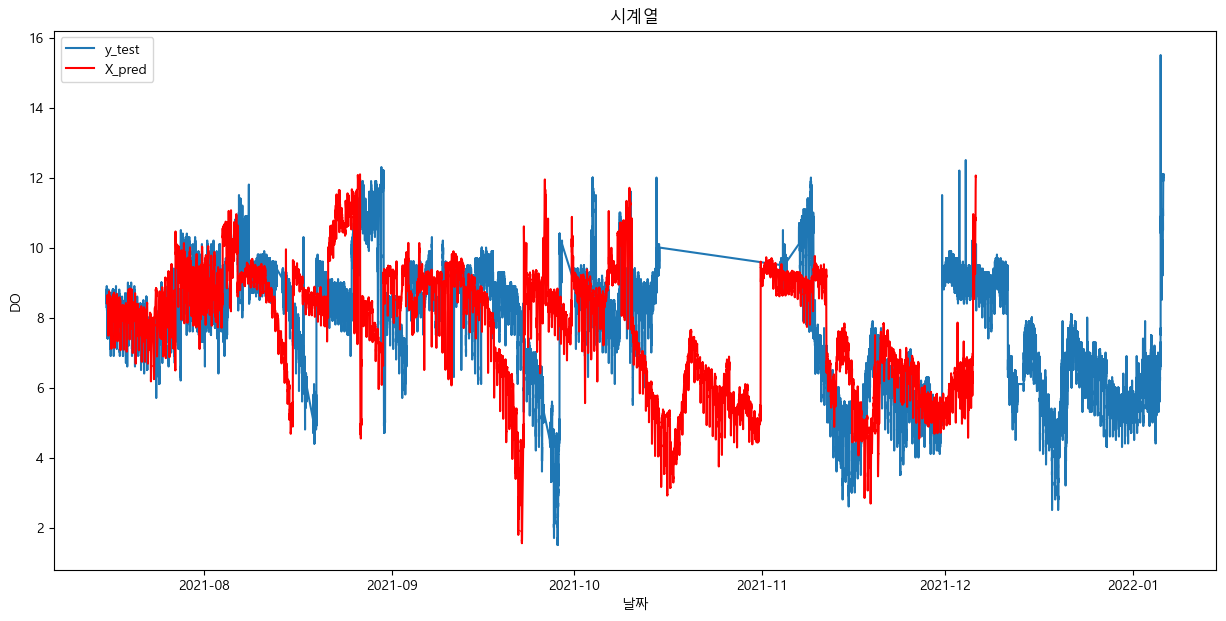

In [43]:
# 그래프 생성
plt.figure(figsize=(15, 7))
plt.plot(japonica_training_features_y.index, japonica_training_features_y, label='actual')  # x축에 년월일, y축에 값
plt.plot(X_pred.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
plt.xlabel('날짜')
plt.ylabel('DO')
plt.title('시계열')
plt.legend(['y_test','X_pred'])
plt.show()

In [11]:
# 하루 동안의 데이터 추출
one_day_data = japonica_training_data.loc['2021-07-17 00:00':'2021-07-17 23:59']
oneday_X_test = one_day_data[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
one_day_data = japonica_training_data.loc['2021-07-17 00:00':'2021-07-17 23:59']
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 180, 9))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 8 nVar: 9
nCar: 1440 nVar: 1


1/1 [==============================] - 0s 57ms/step
1440


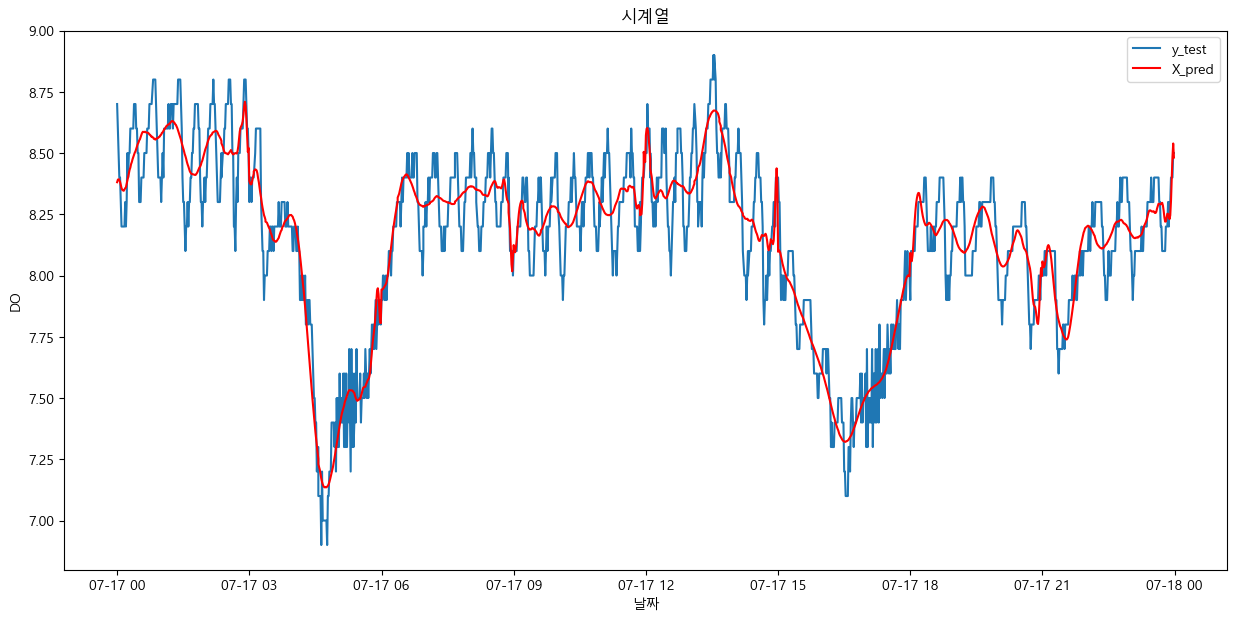

In [12]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)

In [ ]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

# 하루 동안의 데이터 추출
one_day_data = japonica_validation_features_tank.loc['2021-07-16 00:00:00':'2021-07-16 23:59:59']
oneday_X_test = one_day_data[feature_Learning]
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 1, feature_number))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)

In [ ]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

# 하루 동안의 데이터 추출
one_day_data = japonica_validation_features_tank.loc['2021-08-28 00:00:00':'2021-08-28 23:59:59']
oneday_X_test = one_day_data[feature_Learning]
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 1, feature_number))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)